In [40]:
import pandas as pd
import numpy as np
import datetime
from scipy.stats import chi2_contingency, beta
from IPython.display import Image

### 1. Experiment Definition

We developed a new webpage and want to test it's effects on purchase conversion. As such we split our users evenly into 2 groups:
1. **Control**: They get the old webpage
2. **Treatment**: They get the new webpage

Metric we want to track:
$$
\text{purchase conversion} = \frac{\text{# Converted Users}}{\text{# Exposed Users}}
$$

We have 3 weeks of logged exposure/conversion data. Let's define these terms:
1. **Exposure**: A user is bucketed as control or treatment and sees their corresponding page for the first time in the experiment duration
2. **Conversion**: An exposed user makes a purchase within 7 days of being first exposed

Questions you should ask when setting up a test:
- How do you think the experiment will fair?
- Do we have actionable next steps laid out?

### 2. Data Collection

Let's use some A/B testing data: https://www.kaggle.com/saraabdelaal/abtestdata

In [41]:
df = pd.read_csv('/kaggle/input/analyze-ab-test-results-notebook/ab_data.csv')

In [42]:
df.sample(2)

user_id                   timestamp      group landing_page  converted
80744    852479  2017-01-05 21:56:01.762441    control     old_page          1
215885   717951  2017-01-20 01:01:59.929375  treatment     new_page          0

Each row is logged when user is exposed to a webpage.
- **timestamp**: time the user is first exposed
- **group**: bucket
- **landing_page**: Which page are they seeing
- **converted**: Initialized to 0. Changes to 1 if the user makes a purchase within 7 days of first exposure

In [43]:
start_time = datetime.datetime.strptime(df['timestamp'].min(), '%Y-%m-%d %H:%M:%S.%f')
end_time = datetime.datetime.strptime(df['timestamp'].max(), '%Y-%m-%d %H:%M:%S.%f')
data_duration = (end_time - start_time).days

print(f"Number of unique users in experiment: {df['user_id'].nunique()}")
print(f"Data collected for {data_duration} days")
print(f"Landing pages to compare: {df['landing_page'].unique().tolist()}")
print(f"Percentage of users in control: {round(df[df['group']=='control'].shape[0] * 100 / df.shape[0])}%")

Number of unique users in experiment: 290584
Data collected for 21 days
Landing pages to compare: ['old_page', 'new_page']
Percentage of users in control: 50%


### 3. Data Processing

But there are some repeated exposures for some users

In [44]:
sample = df[df['user_id'].isin([746755,722274])]
sample

user_id                   timestamp    group landing_page  converted
29073    746755  2017-01-11 01:28:57.083669  control     new_page          1
105487   722274  2017-01-19 01:46:53.093257  control     old_page          0
262554   722274  2017-01-09 21:21:23.638444  control     new_page          0
286566   746755  2017-01-05 03:40:08.457451  control     old_page          0

Get First timestamp for each username. In this dataset, it is the timestamp of first conversion, but in reality, make sure to do one of the following:
1. Get timestamp of first exposure
2. Remove users with multiple buckets

In [45]:
# 1. Get timestamp of first exposure
first_conversion = sample.groupby('user_id')['timestamp'].min().to_frame().reset_index()
sample = sample.merge(first_conversion, on=['user_id', 'timestamp'])
sample

user_id                   timestamp    group landing_page  converted
0   722274  2017-01-09 21:21:23.638444  control     new_page          0
1   746755  2017-01-05 03:40:08.457451  control     old_page          0

In [46]:
counter = df['user_id'].value_counts()
(counter > 1).value_counts()

False    286690
True       3894
Name: user_id, dtype: int64

3894 (1.34\%) user_ids have been exposed to the old AND new page. It should be okay to remove them

In [47]:
#2. Remove users with multiple buckets
valid_users = pd.DataFrame(counter[counter == 1].index, columns=['user_id'])
df = df.merge(valid_users, on=['user_id'])

In [48]:
# Add week column to see the data as you would during experiment
df['week'] = df['timestamp'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f').isocalendar()[1])
df.sample()

user_id                   timestamp    group landing_page  converted  \
191217   672713  2017-01-15 05:37:55.078026  control     old_page          0   

        week  
191217     2

In [49]:
df['week'].value_counts()

2    91380
3    91056
1    83745
4    20509
Name: week, dtype: int64

### 4. Experiment: Frequentist Approach

In [50]:
# Get Stats
NUM_WEEKS = 4 # Vary number to get experiment data at weekly points in time
experiment_data = df[df['week'] <= NUM_WEEKS]
control = experiment_data[experiment_data['group']=='control']
treatment = experiment_data[experiment_data['group']=='treatment']

control_conversion_perc = round(control['converted'].sum() * 100/ control['converted'].count(), 3)
treatment_conversion_perc = round(treatment['converted'].sum() * 100/ treatment['converted'].count(), 3)
lift = round(treatment_conversion_perc - control_conversion_perc, 3)

print(f"Treatment Conversion Rate: {treatment_conversion_perc}%")
print(f"Control Conversion Rate: {control_conversion_perc}%")
print(f"Lift = {lift}%")

Treatment Conversion Rate: 11.873%
Control Conversion Rate: 12.017%
Lift = -0.144%


In the context of A/B testing, a lift refers to the difference or improvement in performance between two variants being tested. It quantifies the impact of a specific change or variation on a particular metric or key performance indicator (KPI).

When conducting an A/B test, you typically have two versions: the control (A) and the variant (B). The lift is calculated by comparing the performance of the variant against the control. It represents the relative change or uplift in the desired outcome between the two variants.

For example, let's say you're testing two different versions of a website landing page to see which one generates more conversions. The control version (A) has a conversion rate of 5%, while the variant (B) has a conversion rate of 7%. In this case, the lift would be calculated as:

Lift = (B conversion rate - A conversion rate) / A conversion rate = (7% - 5%) / 5% = 40%

So, the lift in this A/B test is 40%, indicating that the variant (B) performed 40% better in terms of conversion rate compared to the control (A). The higher the lift, the more significant the impact of the variation.

Lift is a crucial metric in A/B testing as it helps assess the effectiveness of changes and determines if they are statistically significant or simply due to chance. It enables data-driven decision-making by providing insights into the relative performance of different variants.

#### Chi-Squared Test

$$
H_0: \text{Control & Treatment are independent} \\
H_A: \text{Control & Treatment are not independent} 
$$

In [51]:
# Create Contingency Table for Chi Squared Test
control_converted = control['converted'].sum()
treatment_converted = treatment['converted'].sum()
control_non_converted = control['converted'].count() - control_converted
treatment_non_converted = treatment['converted'].count() - treatment_converted
contingency_table = np.array([[control_converted, control_non_converted], 
                              [treatment_converted, treatment_non_converted]])

In [52]:
contingency_table

array([[ 17220, 126073],
       [ 17025, 126372]])

In [53]:
chi, p_value, _, _ = chi2_contingency(contingency_table, correction=False)

In [54]:
chi, p_value

(1.426794609399621, 0.23228827305833816)

Since the p_value > 0.05, we cannot reject null hypothesis. Hence, we cannot conclude if there exists a relationship between the control and treatment groups.

In [55]:
print(f"{round(p_value * 100, 2)}% probability that a more extreme chi square than {round(chi, 3)} would have occured by chance")

23.23% probability that a more extreme chi square than 1.427 would have occured by chance


But this is tough to interpret. We would to say something about the actual maginitude of lift. Something like this:

In [56]:
print(f"(We CANNOT say this) We are {round(p_value * 100, 2)}% confident that our lift = {lift}%")

(We CANNOT say this) We are 23.23% confident that our lift = -0.144%


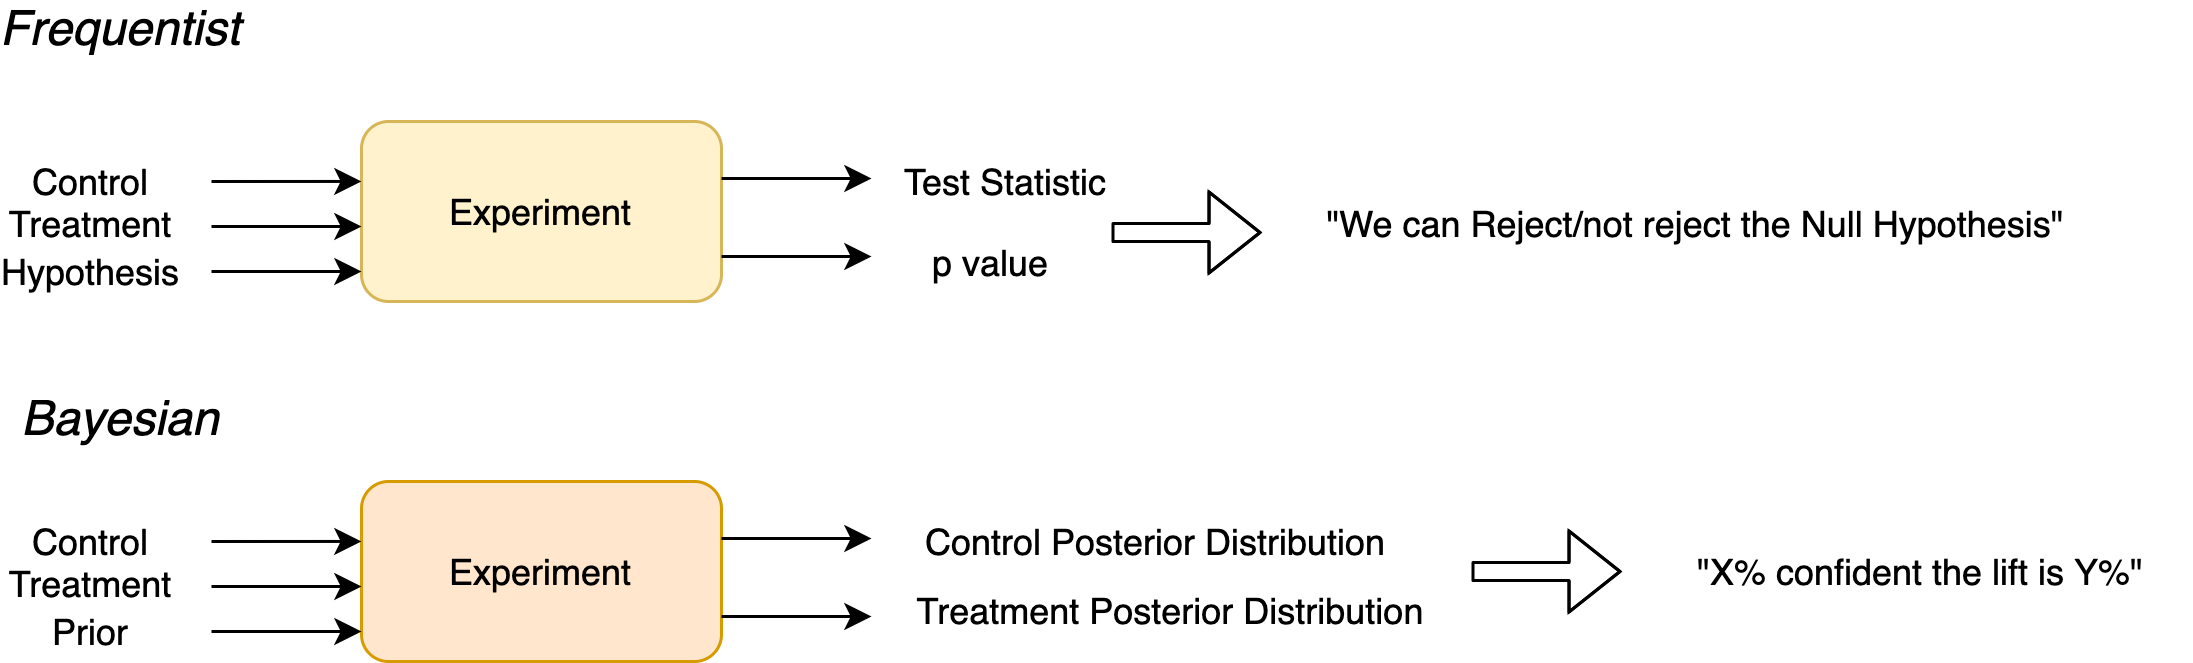

In [57]:
Image(filename= '/kaggle/input/explaa/b_v_f.png') 

### 5. Experiment: Bayesian Approach

We want to input the _prior distribution_ and have the experiment update the parameters to create _posterier distributions_. Since these prior & posterior distributions will be used to sample Conversion Rate, we model them after beta distribtion.

Let's create the prior beta distribtion from the first weeks of conversion data

In [58]:
prior = df[(df['week'] == 1) & (df['group']=='control')]

In [59]:
prior_means = []
for i in range(10000):
    prior_means.append(prior.sample(1000)['converted'].mean())

In [60]:
prior_means[:10]

[0.118, 0.127, 0.131, 0.127, 0.112, 0.122, 0.114, 0.142, 0.125, 0.116]

In [61]:
# Model Beta Distribtion from sample means
prior_alpha, prior_beta, _, _ = beta.fit(prior_means, floc=0, fscale=1)

In [62]:
# Get Stats
NUM_WEEKS = 4 # Vary number to get experiment data at weekly points in time
experiment_data = df[(df['week'] > 1) & (df['week'] <= NUM_WEEKS)]
control = experiment_data[experiment_data['group']=='control']
treatment = experiment_data[experiment_data['group']=='treatment']

control_conversion_perc = round(control['converted'].sum() * 100/ control['converted'].count(), 3)
treatment_conversion_perc = round(treatment['converted'].sum() * 100/ treatment['converted'].count(), 3)
lift = round((treatment_conversion_perc - control_conversion_perc) / control_conversion_perc , 3)

print(f"Treatment Conversion Rate: {treatment_conversion_perc}%")
print(f"Control Conversion Rate: {control_conversion_perc}%")
print(f"Lift = {lift}%")

Treatment Conversion Rate: 11.909%
Control Conversion Rate: 12.058%
Lift = -0.012%


In [63]:
control_converted = control['converted'].sum()
treatment_converted = treatment['converted'].sum()
control_non_converted = control['converted'].count() - control_converted
treatment_non_converted = treatment['converted'].count() - treatment_converted

# Update Prior parameters with experiment conversion rates
posterior_control = beta(prior_alpha + control_converted, prior_beta + control_non_converted)
posterior_treatment = beta(prior_alpha + treatment_converted, prior_beta + treatment_non_converted)

# Sample from Posteriors
control_samples = posterior_control.rvs(1000)
treatment_samples = posterior_treatment.rvs(1000)
probability = np.mean(treatment_samples > control_samples)
print(f"Probability that treatment > control: {probability * 100}%")

Probability that treatment > control: 16.400000000000002%


In [64]:
(control_mu), (control_var) = posterior_control.stats()
(treatment_mu), (treatment_var) = posterior_treatment.stats()
print(f"Control Posterior: Mean: {control_mu}, Variance: {control_var}") 
print(f"Treatment Posterior: Mean: {treatment_mu}, Variance: {treatment_var}") 

Control Posterior: Mean: 0.12056225629064009, Variance: 1.0336678904166383e-06
Treatment Posterior: Mean: 0.11909322492308876, Variance: 1.0245663974559122e-06


We can even make statements like the following which are actionable:

In [65]:
lift_percentage = (treatment_samples - control_samples) / control_samples
print(f"Probability that we are seeing a 2% lift: {np.mean((100 * lift_percentage) > 2) * 100}%")

Probability that we are seeing a 2% lift: 0.1%


Advantages of Bayesian over Frequentist:
- Results are more interpretable than the ones we got from the frequentist approach
- We can interpret results at any point during the experiment. Don't need to wait for an arbitrary "statsig"

##  Beta distribution explained

 Let's explain the beta distribution in a simple way 

Imagine you have a bag of red and blue candies. The beta distribution helps us understand how likely it is to pick a certain number of red candies from the bag.

The beta distribution has two special friends named Alpha and Beta. They help us decide the shape of the distribution. Alpha is like a magical number that tells us how many red candies we expect to get, and Beta is another magical number that tells us how many blue candies we expect to get.

When Alpha and Beta are both 1, it means we have no idea how many red or blue candies are in the bag. It's like a surprise! We could have any number of red candies. So, the distribution is like a straight line, and each number of red candies is equally likely.

But as we start to change the values of Alpha and Beta, the distribution changes shape. If Alpha is bigger than Beta, it means we expect to have more red candies than blue candies. So the distribution becomes more likely to give us more red candies. On the other hand, if Beta is bigger than Alpha, it means we expect to have more blue candies than red candies. So the distribution becomes more likely to give us more blue candies.

The cool thing is that we can use the beta distribution to make predictions. If we know the values of Alpha and Beta, we can figure out the probability of picking a certain number of red candies from the bag. We can even calculate the average number of red candies we expect to get.

So, the beta distribution is like a magical tool that helps us understand and predict how many red candies we might get from a bag of candies, based on what we expect.

## Bayesian A/B testing explained

Let's explain Bayesian A/B testing in a simple way.

Imagine you have two flavors of ice cream, let's say chocolate and vanilla, and you want to know which one people like more. To find out, you decide to do an A/B test.

In a regular A/B test, you would give some people the chocolate ice cream and others the vanilla ice cream, and then you would count how many people like each flavor. The one with more likes would be the winner.

But in a Bayesian A/B test, we do things a little differently. Instead of just counting the likes, we use some magic called statistics to help us make a better decision.

We start by having some initial belief about which flavor is better. Let's say we think chocolate is better because we love it! But we're not entirely sure.

As people start tasting the ice creams and telling us their preferences, we update our beliefs. Each time someone tries an ice cream, we get new information that helps us make a more accurate decision.

The cool thing is that we can use math to calculate the probabilities of each flavor being better based on the information we have. We start with our initial beliefs and then update them as we get more and more data.

So, instead of just looking at the total number of likes, we take into account how confident we are in our beliefs and how much data we have.

In the end, Bayesian A/B testing helps us make a more informed decision about which flavor of ice cream is better. It's like using our initial guess, combined with the feedback we get from people, to figure out the most delicious flavor!

Remember, it's important to try different ice cream flavors and listen to what people think, so we can make the best ice cream choices and make everyone happy!

## Frequentist A/B testing explained

Let's explain frequentist A/B testing in a simple way.

Imagine you have two flavors of ice cream, chocolate and vanilla, and you want to know which one people like more. To find out, you decide to do an A/B test.

In a frequentist A/B test, you gather a group of people and give some of them the chocolate ice cream and others the vanilla ice cream. Then, you count how many people like each flavor and compare the numbers.

If more people like the chocolate ice cream, then we say that chocolate is the winner. If more people like the vanilla ice cream, then vanilla is the winner.

In this test, we don't use any fancy math or statistics. We simply count the number of people who prefer each flavor.

But there's something important to keep in mind. In a frequentist A/B test, we need to make sure that the groups of people trying the ice cream are similar. We want to make sure that the same types of people try both flavors. Otherwise, the results may not be fair.

So, by doing a frequentist A/B test, we can see which flavor of ice cream is more popular based on the number of people who like it. It's a simple way to find out which flavor is the favorite among the people who tried it.

Remember, it's always fun to try different ice cream flavors and see which one you like the most!

## Frequentist vs Baysian explained

Here are some key bullet points to explain the difference between frequentist and Bayesian A/B testing:

Frequentist A/B Test:

* Counts the number of people who like each option.
* Focuses on comparing the numbers to determine which option is better.
* Doesn't involve fancy math or statistics.
* Requires similar groups of people trying both options for fair results.

Bayesian A/B Test:

* Uses initial beliefs and updates them based on new information.
* Uses math to calculate probabilities of each option being better.
* Considers confidence in beliefs and amount of data.
* Helps make a more informed decision about the better option.
* Both tests aim to find the better option, but they use different approaches and involve different calculations.